In [4]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf

## Download the Dataset

In [5]:
f = open('./captcha/words_captcha/spec_train_val.txt')

image_path_to_caption = {}
for val in f.readlines():
    st = val.split(' ')[1].replace('\n', '')
    st = " ".join(st)
    caption = f"<start> {st} <end>"
    image_path = './caption/captcha/words_captcha/' + '%s.png' % (val.split(' ')[0])
    image_path_to_caption[image_path] = caption

In [2]:
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths



train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.append(caption_list)
    img_name_vector.extend([image_path])

In [3]:
top_k = 29
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

NameError: name 'tf' is not defined

In [5]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

def mapping(image_path, train_captions):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0 - 0.5
    train_captions = tf.dtypes.cast(train_captions, tf.float32)
    return img, train_captions



# img_train = img_name_vector[0:96000]
# cap_train = cap_vector[0:96000]
# img_val = img_name_vector[96000:]
# cap_val = cap_vector[96000:]

dataset_train = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_vector)).map(mapping)
# dataset_val = tf.data.Dataset.from_tensor_slices((img_val, cap_val)).map(mapping)


dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(len(img_name_vector))



120000


In [6]:
print(dataset_train)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 7)), types: (tf.float32, tf.float32)>


['<start>', 'r', 'i', 'n', 'g', 's', '<end>']


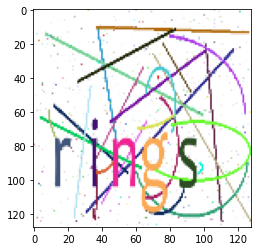

In [7]:
for x, y in dataset_train:
    result = []
    token = y.numpy()[1]
    img_ = x[1].numpy()
    for j in token:
        result.append(tokenizer.index_word[j])
    plt.imshow(img_+ 0.5)
    print(result)
    break

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [8]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [9]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


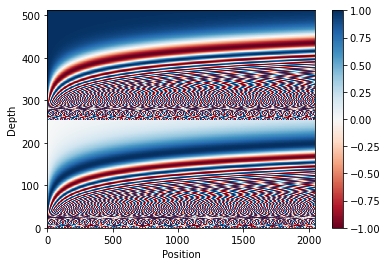

In [10]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [11]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [12]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initilization making it dificult to learn. 

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [115]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        


        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        


        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)


        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)


        return output, attention_weights

In [116]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(1, 60, 512)
(1, 60, 512)


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [16]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [64]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv_2d_1_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=2)
        self.conv_2d_1_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2)
        self.conv_2d_1_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', strides=2)
        self.conv_2d_1_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', strides=2)
        self.conv_2d_1_5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', strides=2)
        self.fc = tf.keras.layers.Dense(1024)



    def call(self, x):
        x = self.conv_2d_1_1(x)
        x = self.conv_2d_1_2(x)
        x = self.conv_2d_1_3(x)
        x = self.conv_2d_1_4(x)
        x = self.conv_2d_1_5(x)
        x = tf.reshape(x, [-1, x.shape[1]*x.shape[2]*x.shape[3]])
        x = self.fc(x)
        x = tf.nn.relu(x)

        

        return x  # (batch_size, input_seq_len, d_model)

In [65]:
temp_embedding = tf.random.uniform((64, 7), dtype=tf.float64, minval=0, maxval=28)
temp_img = tf.random.uniform((64, 128), dtype=tf.float64, minval=-1, maxval=1)


sample_encoder = Encoder()


temp_input = tf.random.uniform((64, 128, 128, 3), dtype=tf.float64, minval=-1, maxval=1)

sample_encoder_output = sample_encoder(temp_input)

sample_encoder_output.shape



TensorShape([64, 1024])

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [117]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [131]:


sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=29,
                         maximum_position_encoding=7)
temp_input = tf.random.uniform((1, 7), dtype=tf.float64, minval=0, maxval=28)
sample_encoder_output = tf.random.uniform((1, 128), dtype=tf.float64, minval=0, maxval=28)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)


tf.squeeze(attn['decoder_layer1_block1'])

(1, 7)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)
(1, 7, 512)


<tf.Tensor: shape=(8, 7, 7), dtype=float32, numpy=
array([[[0.12770106, 0.15251262, 0.1701825 , 0.05158136, 0.16371697,
         0.16111252, 0.17319295],
        [0.30591142, 0.12043509, 0.13342309, 0.1213    , 0.11603209,
         0.10395498, 0.09894332],
        [0.39528134, 0.2197589 , 0.14158873, 0.07010265, 0.11113981,
         0.03183929, 0.03028929],
        [0.27601856, 0.27455398, 0.08117077, 0.06914489, 0.06314176,
         0.11232066, 0.1236493 ],
        [0.41060606, 0.2377253 , 0.10619845, 0.09400689, 0.07536472,
         0.03935387, 0.03674472],
        [0.2719224 , 0.21912599, 0.14639588, 0.09352971, 0.11564942,
         0.07732409, 0.07605252],
        [0.27125135, 0.21566296, 0.14663358, 0.10010087, 0.11891958,
         0.07497456, 0.07245713]],

       [[0.03030633, 0.17244788, 0.10129422, 0.09440994, 0.13652001,
         0.25607097, 0.20895067],
        [0.08078674, 0.05726548, 0.04768449, 0.3373921 , 0.03845352,
         0.20205514, 0.23636249],
        [0.02217491,

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [68]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder()

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, x, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        x = self.encoder(x)
    
        dec_output, attention_weights = self.decoder(
            tar, x, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [69]:
sample_transformer = Transformer(
    num_layers=2, d_model=128, num_heads=8, dff=2048,
    input_vocab_size=29, target_vocab_size=29,
    pe_input=10000, pe_target=6000)


temp_input = tf.random.uniform((64, 128, 128, 3), dtype=tf.float64, minval=-1, maxval=1)
temp_target = tf.random.uniform((64, 7), dtype=tf.int32, minval=0, maxval=28)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,enc_padding_mask=None,look_ahead_mask=None,dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 7, 29])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [70]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [71]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [72]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [73]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [74]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    logics = (real == tf.dtypes.cast(pred, tf.float32))
    summation = tf.reduce_sum(tf.cast(logics, tf.float32))
    return summation / (64*6)

In [75]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [76]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=29,
    target_vocab_size=29,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [77]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


temp_embedding = tf.random.uniform((64, 7), dtype=tf.float64, minval=0, maxval=28)
temp_img = tf.random.uniform((64, 128), dtype=tf.float64, minval=-1, maxval=1)

enc_padding_mask, combined_mask, dec_padding_mask = create_masks(temp_img, temp_embedding)

In [78]:
EPOCHS = 25

In [79]:
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     None,
                                     combined_mask,
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    prediction = tf.argmax(predictions, axis=-1)

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, prediction))

In [80]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [81]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  # inp -> img, tar -> captioning
    for (batch, (inp, tar)) in enumerate(dataset_train):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-5
Epoch 1 Batch 0 Loss 4.2751 Accuracy 0.0234
Epoch 1 Batch 50 Loss 3.7606 Accuracy 0.0630
Epoch 1 Batch 100 Loss 3.3898 Accuracy 0.1176
Epoch 1 Batch 150 Loss 3.1992 Accuracy 0.1430
Epoch 1 Batch 200 Loss 3.0639 Accuracy 0.1593
Epoch 1 Batch 250 Loss 2.9711 Accuracy 0.1699
Epoch 1 Batch 300 Loss 2.8988 Accuracy 0.1789
Epoch 1 Batch 350 Loss 2.8377 Accuracy 0.1860
Epoch 1 Batch 400 Loss 2.7875 Accuracy 0.1916
Epoch 1 Batch 450 Loss 2.7450 Accuracy 0.1962
Epoch 1 Batch 500 Loss 2.7077 Accuracy 0.1998
Epoch 1 Batch 550 Loss 2.6751 Accuracy 0.2030
Epoch 1 Batch 600 Loss 2.6470 Accuracy 0.2057
Epoch 1 Batch 650 Loss 2.6224 Accuracy 0.2086
Epoch 1 Batch 700 Loss 2.5994 Accuracy 0.2112
Epoch 1 Batch 750 Loss 2.5787 Accuracy 0.2134
Epoch 1 Batch 800 Loss 2.5590 Accuracy 0.2154
Epoch 1 Batch 850 Loss 2.5411 Accuracy 0.2173
Epoch 1 Batch 900 Loss 2.5235 Accuracy 0.2194
Epoch 1 Batch 950 Loss 2.5074 Accuracy 0.2214
Epoch 1 Batch 1000 Loss

Epoch 5 Batch 600 Loss 0.5429 Accuracy 0.6804
Epoch 5 Batch 650 Loss 0.5415 Accuracy 0.6812
Epoch 5 Batch 700 Loss 0.5392 Accuracy 0.6817
Epoch 5 Batch 750 Loss 0.5369 Accuracy 0.6820
Epoch 5 Batch 800 Loss 0.5346 Accuracy 0.6828
Epoch 5 Batch 850 Loss 0.5322 Accuracy 0.6835
Epoch 5 Batch 900 Loss 0.5302 Accuracy 0.6843
Epoch 5 Batch 950 Loss 0.5272 Accuracy 0.6852
Epoch 5 Batch 1000 Loss 0.5253 Accuracy 0.6857
Epoch 5 Batch 1050 Loss 0.5226 Accuracy 0.6866
Epoch 5 Batch 1100 Loss 0.5208 Accuracy 0.6871
Epoch 5 Batch 1150 Loss 0.5184 Accuracy 0.6877
Epoch 5 Batch 1200 Loss 0.5158 Accuracy 0.6887
Epoch 5 Batch 1250 Loss 0.5134 Accuracy 0.6894
Epoch 5 Batch 1300 Loss 0.5111 Accuracy 0.6901
Epoch 5 Batch 1350 Loss 0.5094 Accuracy 0.6905
Epoch 5 Batch 1400 Loss 0.5075 Accuracy 0.6912
Epoch 5 Batch 1450 Loss 0.5058 Accuracy 0.6919
Epoch 5 Batch 1500 Loss 0.5038 Accuracy 0.6925
Epoch 5 Batch 1550 Loss 0.5018 Accuracy 0.6930
Epoch 5 Batch 1600 Loss 0.4994 Accuracy 0.6938
Epoch 5 Batch 1650 Lo

Epoch 9 Batch 1300 Loss 0.1802 Accuracy 0.7855
Epoch 9 Batch 1350 Loss 0.1800 Accuracy 0.7855
Epoch 9 Batch 1400 Loss 0.1797 Accuracy 0.7856
Epoch 9 Batch 1450 Loss 0.1797 Accuracy 0.7857
Epoch 9 Batch 1500 Loss 0.1792 Accuracy 0.7860
Epoch 9 Batch 1550 Loss 0.1788 Accuracy 0.7860
Epoch 9 Batch 1600 Loss 0.1784 Accuracy 0.7862
Epoch 9 Batch 1650 Loss 0.1779 Accuracy 0.7863
Epoch 9 Batch 1700 Loss 0.1772 Accuracy 0.7865
Epoch 9 Batch 1750 Loss 0.1766 Accuracy 0.7866
Epoch 9 Batch 1800 Loss 0.1762 Accuracy 0.7868
Epoch 9 Batch 1850 Loss 0.1756 Accuracy 0.7870
Epoch 9 Loss 0.1755 Accuracy 0.7871
Time taken for 1 epoch: 180.66 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-14
Epoch 10 Batch 0 Loss 0.1078 Accuracy 0.7943
Epoch 10 Batch 50 Loss 0.1554 Accuracy 0.7928
Epoch 10 Batch 100 Loss 0.1555 Accuracy 0.7917
Epoch 10 Batch 150 Loss 0.1554 Accuracy 0.7929
Epoch 10 Batch 200 Loss 0.1550 Accuracy 0.7921
Epoch 10 Batch 250 Loss 0.1560 Accuracy 0.7912
Epoch 10 Batch 300 Los

Epoch 13 Batch 1800 Loss 0.0911 Accuracy 0.8114
Epoch 13 Batch 1850 Loss 0.0910 Accuracy 0.8114
Epoch 13 Loss 0.0909 Accuracy 0.8114
Time taken for 1 epoch: 179.55 secs

Saving checkpoint for epoch 14 at ./checkpoints/train/ckpt-18
Epoch 14 Batch 0 Loss 0.0670 Accuracy 0.8333
Epoch 14 Batch 50 Loss 0.0881 Accuracy 0.8121
Epoch 14 Batch 100 Loss 0.0830 Accuracy 0.8134
Epoch 14 Batch 150 Loss 0.0837 Accuracy 0.8139
Epoch 14 Batch 200 Loss 0.0818 Accuracy 0.8141
Epoch 14 Batch 250 Loss 0.0825 Accuracy 0.8136
Epoch 14 Batch 300 Loss 0.0827 Accuracy 0.8131
Epoch 14 Batch 350 Loss 0.0824 Accuracy 0.8132
Epoch 14 Batch 400 Loss 0.0824 Accuracy 0.8132
Epoch 14 Batch 450 Loss 0.0828 Accuracy 0.8133
Epoch 14 Batch 500 Loss 0.0830 Accuracy 0.8136
Epoch 14 Batch 550 Loss 0.0823 Accuracy 0.8137
Epoch 14 Batch 600 Loss 0.0820 Accuracy 0.8138
Epoch 14 Batch 650 Loss 0.0821 Accuracy 0.8139
Epoch 14 Batch 700 Loss 0.0818 Accuracy 0.8139
Epoch 14 Batch 750 Loss 0.0814 Accuracy 0.8139
Epoch 14 Batch 800 

Epoch 18 Batch 250 Loss 0.0562 Accuracy 0.8211
Epoch 18 Batch 300 Loss 0.0556 Accuracy 0.8207
Epoch 18 Batch 350 Loss 0.0546 Accuracy 0.8213
Epoch 18 Batch 400 Loss 0.0544 Accuracy 0.8214
Epoch 18 Batch 450 Loss 0.0539 Accuracy 0.8218
Epoch 18 Batch 500 Loss 0.0542 Accuracy 0.8220
Epoch 18 Batch 550 Loss 0.0545 Accuracy 0.8218
Epoch 18 Batch 600 Loss 0.0546 Accuracy 0.8217
Epoch 18 Batch 650 Loss 0.0546 Accuracy 0.8216
Epoch 18 Batch 700 Loss 0.0542 Accuracy 0.8217
Epoch 18 Batch 750 Loss 0.0542 Accuracy 0.8216
Epoch 18 Batch 800 Loss 0.0542 Accuracy 0.8215
Epoch 18 Batch 850 Loss 0.0543 Accuracy 0.8215
Epoch 18 Batch 900 Loss 0.0543 Accuracy 0.8216
Epoch 18 Batch 950 Loss 0.0541 Accuracy 0.8218
Epoch 18 Batch 1000 Loss 0.0538 Accuracy 0.8220
Epoch 18 Batch 1050 Loss 0.0535 Accuracy 0.8221
Epoch 18 Batch 1100 Loss 0.0531 Accuracy 0.8222
Epoch 18 Batch 1150 Loss 0.0531 Accuracy 0.8222
Epoch 18 Batch 1200 Loss 0.0535 Accuracy 0.8221
Epoch 18 Batch 1250 Loss 0.0534 Accuracy 0.8223
Epoch 1

Epoch 22 Batch 750 Loss 0.0382 Accuracy 0.8261
Epoch 22 Batch 800 Loss 0.0380 Accuracy 0.8263
Epoch 22 Batch 850 Loss 0.0379 Accuracy 0.8263
Epoch 22 Batch 900 Loss 0.0382 Accuracy 0.8262
Epoch 22 Batch 950 Loss 0.0382 Accuracy 0.8264
Epoch 22 Batch 1000 Loss 0.0383 Accuracy 0.8265
Epoch 22 Batch 1050 Loss 0.0383 Accuracy 0.8265
Epoch 22 Batch 1100 Loss 0.0382 Accuracy 0.8265
Epoch 22 Batch 1150 Loss 0.0380 Accuracy 0.8265
Epoch 22 Batch 1200 Loss 0.0380 Accuracy 0.8266
Epoch 22 Batch 1250 Loss 0.0378 Accuracy 0.8265
Epoch 22 Batch 1300 Loss 0.0377 Accuracy 0.8266
Epoch 22 Batch 1350 Loss 0.0376 Accuracy 0.8267
Epoch 22 Batch 1400 Loss 0.0376 Accuracy 0.8267
Epoch 22 Batch 1450 Loss 0.0375 Accuracy 0.8268
Epoch 22 Batch 1500 Loss 0.0377 Accuracy 0.8268
Epoch 22 Batch 1550 Loss 0.0376 Accuracy 0.8268
Epoch 22 Batch 1600 Loss 0.0376 Accuracy 0.8269
Epoch 22 Batch 1650 Loss 0.0375 Accuracy 0.8269
Epoch 22 Batch 1700 Loss 0.0375 Accuracy 0.8270
Epoch 22 Batch 1750 Loss 0.0376 Accuracy 0.82

In [92]:
def evaluate(img):
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    result.append('<start>')

    for i in range(7):
        temp_img = tf.random.uniform((1, 128), dtype=tf.float64, minval=-1, maxval=1)

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(temp_img, output)
        
        predictions, attention_weights = transformer(img,
                                                 output,
                                                 False,
                                                 None,
                                                 combined_mask,
                                                 None)
        
        predictions = predictions[:, -1:, :] 
        predicted_id = tf.argmax(predictions.numpy(), axis=-1)
        result.append(tokenizer.index_word[predicted_id.numpy()[0][0]])
        to_append = tf.cast(predicted_id, tf.int32)
        # as its input.
        output = tf.concat([output, to_append], axis=-1)
        

        if tokenizer.index_word[predicted_id.numpy()[0][0]] == '<end>':
            return result


    return result

Predict Caption: <start> h e e l <end>
Real Caption: <start> h e e l <end> <pad>


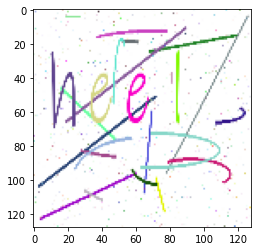

In [109]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)




for x, y in dataset_train:
    result = []
    token = y.numpy()[2]
    img_ = x[2]
    img_ = tf.expand_dims(img_, axis=0)
    for j in token:
        result.append(tokenizer.index_word[j])
    predict = evaluate(img_)
    print('Predict Caption:', ' '.join(predict))
    plt.imshow(x[2].numpy()+ 0.5)
    break



print('Real Caption:', ' '.join(result))

In [82]:
print(count)

1875


In [83]:
print(correct)

1855


In [112]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])



In [114]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 7,50))).shape

TensorShape([64, 7, 512])